In [24]:
from qiskit.quantum_info import Operator
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
import numpy as np
import math

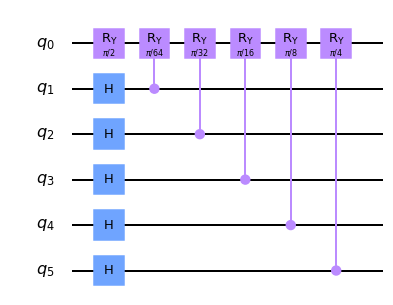

In [25]:
def operatorA(n, a, b):
        
        qc = QuantumCircuit(n, name = 'A')
        
        qc.h(range(1,n))
        qc.ry(2*a, 0)
        
        for qubitNo in range(1,n):
            qc.cry(((b-a)/(pow(2, n-1-qubitNo))), qubitNo, 0)
            
        return qc
    
operatorA(6, np.pi/4, np.pi/2).draw('mpl')

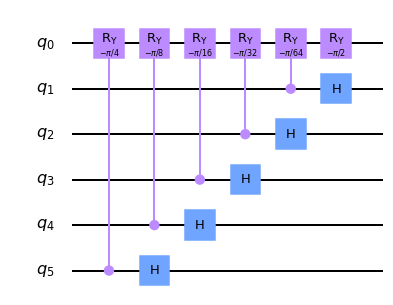

In [26]:
def operatorAbar(n, a, b):
        
        qc = QuantumCircuit(n, name = 'Abar')
        
        for qubitNoTemp in range(1,n):
            qubitNo = n - qubitNoTemp
            qc.cry((-(b-a)/(pow(2, n-1-qubitNo))), qubitNo, 0)
        
        qc.ry(-2*a, 0)
        qc.h(range(1,n))
        
        return qc
    
operatorAbar(6, np.pi/4, np.pi/2).draw('mpl')

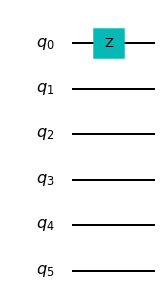

In [27]:
def operatorSx(n):
    qc = QuantumCircuit(n, name = 'Sx')
    qc.z(0)
    return qc

operatorSx(6).draw('mpl')

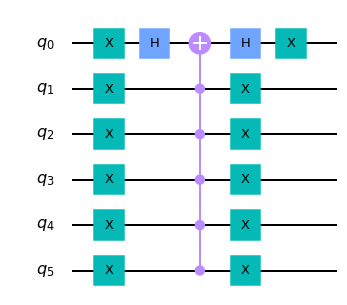

In [28]:
def operatorS0(n):
    qc = QuantumCircuit(n, name = 'S0')
    qc.x(range(n))
    qc.h(0)
    qc.mcx(list(range(1,n)), 0)
    qc.h(0)
    qc.x(range(n))
    
    return qc

operatorS0(6).draw('mpl')

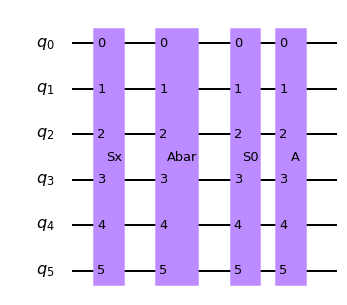

In [29]:
def operatorQ(n, a, b):
    
    qc = QuantumCircuit(n, name = 'Q')
    qc.append(operatorSx(n), range(n))
    qc.append(operatorAbar(n, a, b), range(n))
    qc.append(operatorS0(n), range(n))
    qc.append(operatorA(n, a, b), range(n))
    
    return qc

operatorQ(6, np.pi/4, np.pi/2).draw('mpl')

In [30]:
def post_process_MLQAE(goodHits, nShots, m, n, a, b):
    
    lBoundTheta = 0
    uBoundTheta = np.pi/2
    
    theta = np.linspace(lBoundTheta, uBoundTheta, 1000)
    
    func_MLE = np.ones_like(theta)
    
    for iteration in range(m):
        hits = goodHits[iteration]
        misses = nShots - hits
        k = math.floor(pow(2,iteration-1))
        coeff = 2*k + 1
       
        #func_MLE *= pow(np.sin((coeff)*theta), hits)*pow(np.cos((coeff)*theta), misses)*1e100 # !!Underflow still possible
        
        func_MLE += hits*np.log(np.abs(np.sin((coeff)*theta) + 1e-7)) + misses*np.log(np.abs(np.cos((coeff)*theta) + 1e-7))
        #case-specific, fails to deal with treating negative signs
        
    return theta[np.argmax(func_MLE)]

In [48]:
qcl = []

def MLQAE_EIS(m, n, a, b):
    
    nShots = 1000
    goodHits = []
    
    for iteration in range(m):
            
            qc = QuantumCircuit(n, 1, name = 'MLQAE')
            qc.append(operatorA(n, a, b), range(n))
            
            noOfQ = math.floor(pow(2,iteration-1))
            
            for circuitQ in range(noOfQ):
                qc.append(operatorQ(n, a, b), range(n))
                
            qc.measure(0, 0)
            
            qcl.append(qc)
            
            from qiskit import Aer, execute
            simulator = Aer.get_backend('qasm_simulator')
            counts = execute(qc, backend=simulator, shots=nShots).result().get_counts(qc)
            
            #counts is a dictionary
            key = '1'
            
            if key in counts.keys():
                goodHits.append(counts[key])
            else:
                goodHits.append(0)
            
    
    #Post-processing
    measured_theta = post_process_MLQAE(goodHits, nShots, m, n, a, b)
    integral = (b-a)*pow(math.sin(measured_theta), 2)    
    print("The value of the integral is ", integral)
    return integral


MLQAE_EIS(4, 10, np.pi/4, np.pi/2)       # more depth, more accuracy

The value of the integral is  0.6427483705611374


0.6427483705611374

In [45]:
import matplotlib.pyplot as plt

for circuit in qcl:
    print(circuit)

     ┌────┐┌─┐
q_0: ┤0   ├┤M├
     │    │└╥┘
q_1: ┤1   ├─╫─
     │    │ ║ 
q_2: ┤2   ├─╫─
     │    │ ║ 
q_3: ┤3   ├─╫─
     │    │ ║ 
q_4: ┤4   ├─╫─
     │  A │ ║ 
q_5: ┤5   ├─╫─
     │    │ ║ 
q_6: ┤6   ├─╫─
     │    │ ║ 
q_7: ┤7   ├─╫─
     │    │ ║ 
q_8: ┤8   ├─╫─
     │    │ ║ 
q_9: ┤9   ├─╫─
     └────┘ ║ 
c: 1/═══════╩═
            0 
     ┌────┐┌────┐┌─┐
q_0: ┤0   ├┤0   ├┤M├
     │    ││    │└╥┘
q_1: ┤1   ├┤1   ├─╫─
     │    ││    │ ║ 
q_2: ┤2   ├┤2   ├─╫─
     │    ││    │ ║ 
q_3: ┤3   ├┤3   ├─╫─
     │    ││    │ ║ 
q_4: ┤4   ├┤4   ├─╫─
     │  A ││  Q │ ║ 
q_5: ┤5   ├┤5   ├─╫─
     │    ││    │ ║ 
q_6: ┤6   ├┤6   ├─╫─
     │    ││    │ ║ 
q_7: ┤7   ├┤7   ├─╫─
     │    ││    │ ║ 
q_8: ┤8   ├┤8   ├─╫─
     │    ││    │ ║ 
q_9: ┤9   ├┤9   ├─╫─
     └────┘└────┘ ║ 
c: 1/═════════════╩═
                  0 
     ┌────┐┌────┐┌────┐┌─┐
q_0: ┤0   ├┤0   ├┤0   ├┤M├
     │    ││    ││    │└╥┘
q_1: ┤1   ├┤1   ├┤1   ├─╫─
     │    ││    ││    │ ║ 
q_2: ┤2   ├┤2   ├┤2   ├─╫─
     │    

In [49]:
def integrate_sin_sq(m, n, a, b):
    integral = MLQAE_EIS(m, n, a, b)
    return integral

In [50]:
def integrate_cos_sq(m, n, a, b):
    sin_sq = MLQAE_EIS(m, n, a, b)
    integral = 1*(b-a) - sin_sq
    return integral

In [51]:
def integrate_cos(m, n, a, b):
    cos_sq = integrate_cos_sq(m, n, a/2, b/2)
    sin_sq = integrate_sin_sq(m, n, a/2, b/2)
    integral = 2*cos_sq - 2*sin_sq
    return integral

In [52]:
def integrate_sin(m, n, a, b):
    integral = integrate_cos(m, n, np.pi/2 - b, np.pi/2 - a)
    return integral

In [53]:
integrate_sin(6, 12, 0, np.pi/2)

The value of the integral is  0.14264979283631085
The value of the integral is  0.14264979283631085


1.0001971554496532

In [ ]:
def integrate_sin_kx(m, n, k, a, b):
    integral = integrate_sin(m, n, k*a, k*b)/k

In [ ]:
def integrate_cos_kx(m, n, k, a, b):
    integral = integrate_cos(m, n, k*a, k*b)/k